# Score Matching on synthetic datasets

This notebook focuses on evaluating the scores of samples generated either from a Gaussian Mixture Model (GMM), or a banana-shaped density, using either Denoising Score Matching or Sliced Score Matching.

In [1]:
import sys
local_path = '../'
sys.path.append(local_path)

from utils.density_utils import gaussian_mixture_model_sampling, banana_sampling
from utils.plot_utils import plot_real_predicted_scores

from models.models import BasicNetwork
from models.train import DenoisingScoreMatching, SlicedScoreMatching

import numpy as np
import matplotlib.pyplot as plt

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In the cell below, the user can choose to use a Gaussian Mixture Model ("GMM"), a banana-shaped density ("banana"), Denoising Score Matching ("DSM"), Sliced Score Matching ("SSM").

In [2]:
# data = "GMM"
data = "banana"

# method = "DSM"
method = "SSM"

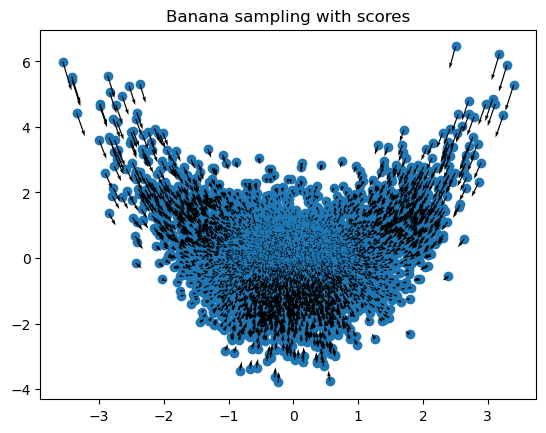

In [3]:
# Create and plot the data (Gaussian mixture model or banana)

# Parameters
n_samples = 5000

if data == "GMM":
    # Gaussian mixture model
    weights = np.array([0.5, 0.5])
    means = np.array([[0., 0.], [5., 10.]])
    covariances = np.array([np.eye(2), np.eye(2)])

    # Generate samples
    samples, cluster, scores = gaussian_mixture_model_sampling(n_samples, weights, means, covariances)

    # Plot the samples and the scores
    plt.figure()
    plt.scatter(samples[:, 0], samples[:, 1], c=cluster)
    plt.quiver(samples[:, 0], samples[:, 1], scores[:, 0], scores[:, 1])
    plt.title('Gaussian mixture model sampling with scores')
    plt.show()
elif data == "banana":
    # Banana
    samples, scores = banana_sampling(n_samples)

    # Plot the samples and the scores
    plt.figure()
    plt.scatter(samples[:, 0], samples[:, 1])
    plt.quiver(samples[:, 0], samples[:, 1], scores[:, 0], scores[:, 1])
    plt.title('Banana sampling with scores')
    plt.show()
else:
    raise ValueError(f"Unknown data: {data}")

Here, we use a basic model composed of 3 linear layers, and using ReLU function.

In [4]:
# Define the model
model = BasicNetwork().to(device)

# Parameters
lr = 1e-3
n_iter = 500 if method == "DSM" else 50
sigma = 1

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

# Train the model
if method == "DSM":
    list_loss = DenoisingScoreMatching(model, optimizer, sigma, device).train(samples, n_iter)
elif method == "SSM":
    list_loss = SlicedScoreMatching(model, optimizer, device).train(samples, n_iter)
    
predicted_scores = model(torch.tensor(samples, dtype = torch.float32, device = device)).detach().cpu().numpy()

Sliced Score Matching:   0%|          | 0/50 [00:00<?, ?it/s]

/users/eleves-b/2021/lucas.versini/.local/lib/python3.9/site-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Sliced Score Matching: 100%|██████████| 50/50 [00:00<00:00, 171.98it/s, loss=0.00794]


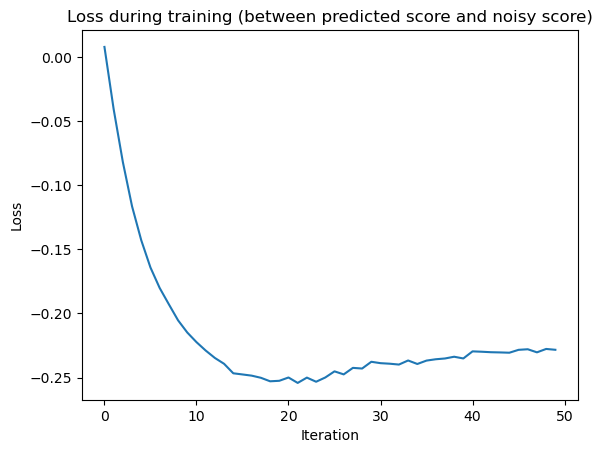

In [5]:
# Plot the loss
plt.figure()
plt.plot(list_loss)
plt.title('Loss during training (between predicted score and noisy score)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

/users/eleves-b/2021/lucas.versini/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


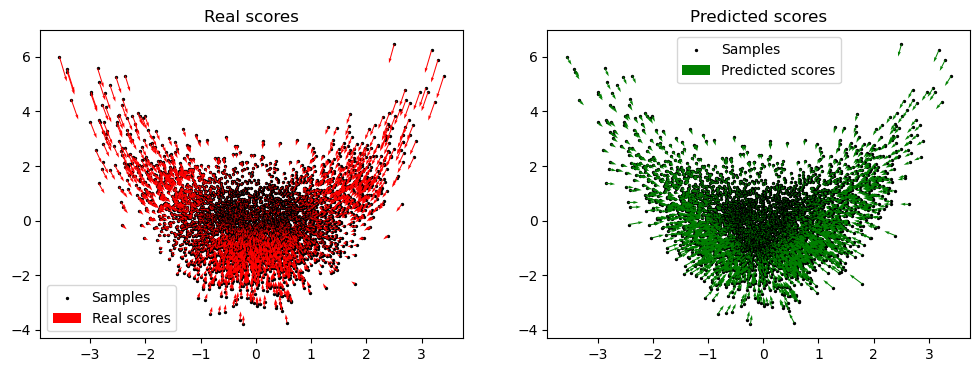

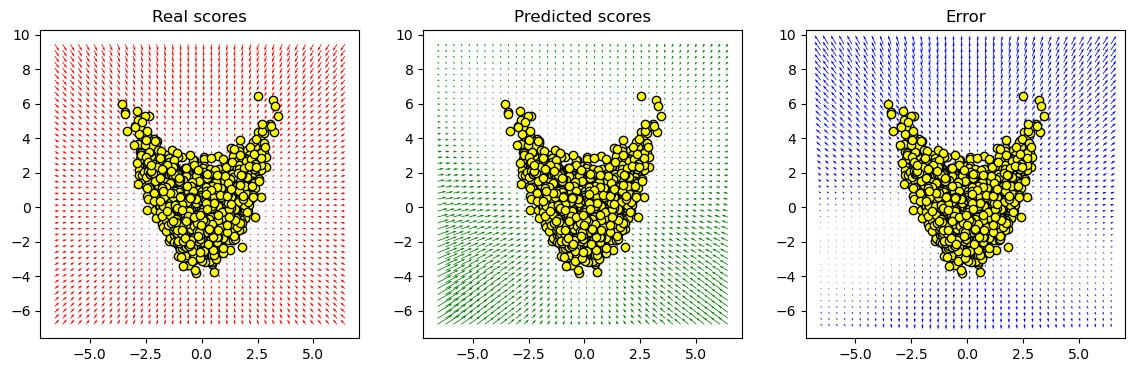

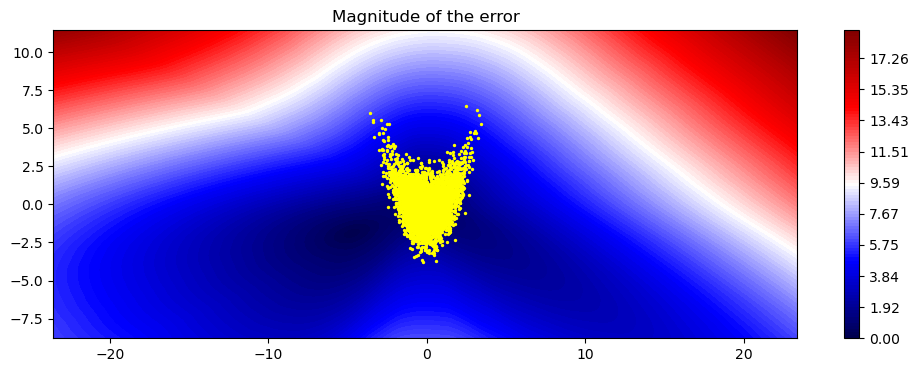

In [6]:
# Plot real score and predicted score
if data == "banana":
    weights, means, covariances = np.array([1.]), np.array([[0., 0.]]), np.array([np.eye(2)])
plot_real_predicted_scores(samples, scores, predicted_scores, model, device, weights, means, covariances)

Our model gives good predictions of the score near the means, and rather bad ones away from the means. This is because far from the means, no sample is observed, so the model cannot learn the score.